In [1]:
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from utility import dataset, ToTensor
from cnn_mlp import CNN_MLP
from cnn_lstm import CNN_LSTM
from resnet18 import Resnet18_MLP

/common/home/pv217/.conda/envs/gln_new/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy import misc

In [3]:
# !pip install scipy

In [4]:
class args():
    model='CNN_MLP'
    epochs=300
    batch_size=32
    seed=12345
    dataset = 'iRaven'
    device = 2
    load_workers = 16
    resume = False
    path = "/common/users/pv217/four_config_data_pth/pritish_data"
    save = "/common/users/pv217/model_checkpoints/full_cnn_lstm"
    img_size = 80
    lr = 1e-4
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 0.0
    cuda = torch.cuda.is_available()    

In [5]:
args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [6]:
data_path = "/common/users/pv217/four_config_data_pth/pritish_data"

In [7]:
train = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]),shuffle=False,
                rotate=True,vertical_flip=True, vertical_roll = True,
                horizontal_flip = True, horizontal_roll= True, max_rotate_angle = 180
               )
valid = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
test = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))

In [8]:
trainloader = DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=16)
validloader = DataLoader(valid, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=16)

In [9]:
if args.model == "CNN_MLP":
    model = CNN_MLP(args)
elif args.model == "CNN_LSTM":
    model = CNN_LSTM(args)
elif args.model == "Resnet18_MLP":
    model = Resnet18_MLP(args)

In [10]:
if args.resume:
    model.load_model(args.save, 0)
    print('Loaded model')
if args.cuda:
    model = model.cuda()

In [11]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(trainloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.train_(image, target, meta_target)
        #print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    print(epoch)
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)


In [12]:
def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [13]:
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [ ]:
epoch_lst = []
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
test_acc_lst = []

for epoch in range(0, args.epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_acc = test(epoch)
    epoch_lst.append(epoch)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)
#     model.save_model(args.save, epoch, val_acc, val_loss)
    
    

0
Avg Training Loss: 2.091481
Total Validation Loss: 2.086365, Acc: 12.4500
Total Testing Acc: 13.1625
1
Avg Training Loss: 2.085933
Total Validation Loss: 2.083294, Acc: 11.8250
Total Testing Acc: 12.8750
2
Avg Training Loss: 2.083035
Total Validation Loss: 2.081277, Acc: 12.7000
Total Testing Acc: 12.9750


In [26]:
import pandas as pd
import seaborn as sns

In [27]:
training_stats = pd.DataFrame({'epoch':epoch_lst,
 'training_loss':train_loss_lst,
 'training_accuracy':train_acc_lst,
 'validation_loss':val_loss_lst,
 'validation_accuracy':val_acc_lst,
 'test_accuracy':test_acc_lst
})

In [28]:
training_stats = training_stats.set_index('epoch')

In [29]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='epoch'>

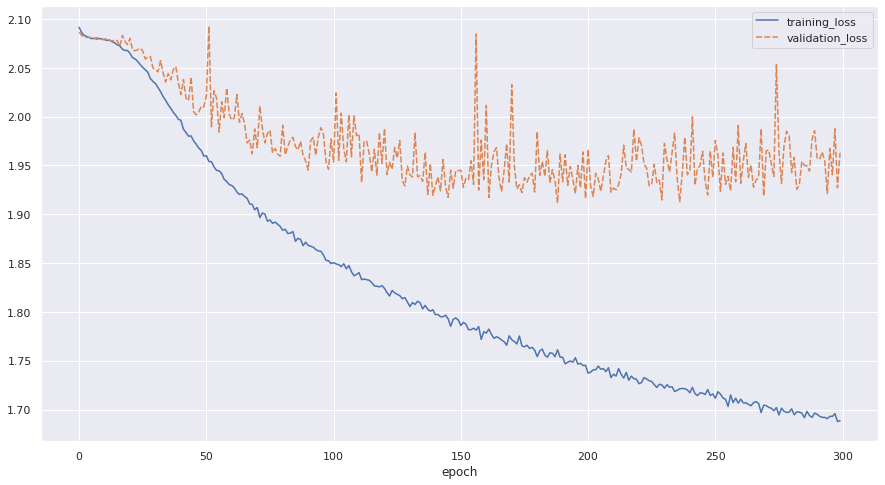

In [30]:
sns.lineplot(data=training_stats[['training_loss','validation_loss']])

<AxesSubplot:xlabel='epoch'>

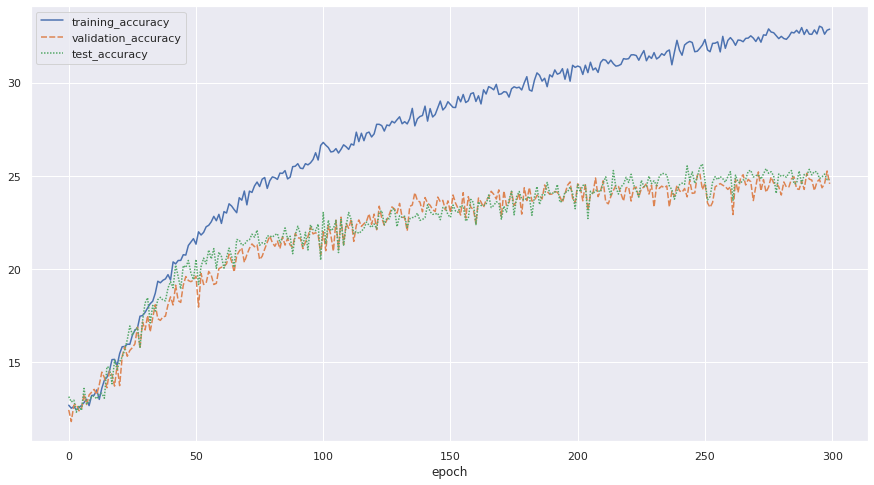

In [31]:
sns.lineplot(data=training_stats[['training_accuracy','validation_accuracy','test_accuracy']])

#### Checking Model performance on each configuration  

In [32]:
def validate():
    model.eval()
    val_loss = 0
    accuracy = 0
    epoch = 1
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
#         print(counter)
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
        loss, acc = model.validate_(image, target, meta_target)
#         print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
#         print(counter)
    if counter >0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return  acc_all/float(counter)

def test():
    model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [33]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

Total Validation Loss: 2.066840, Acc: 28.4226
Total Testing Acc: 30.4563
Total Validation Loss: 2.032018, Acc: 20.6845
Total Testing Acc: 19.6925
Total Validation Loss: 1.936960, Acc: 21.5774
Total Testing Acc: 20.6845
Total Validation Loss: 1.816054, Acc: 27.5298
Total Testing Acc: 28.3234


In [34]:
pd.DataFrame({'configaration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list})

,configaration,validation_accuracy,test_accuracy
0,center_single,28.422619,30.456349
1,distribute_four,20.684524,19.692460
2,in_distribute_four_out_center_single,21.577381,20.684524
3,left_center_single_right_center_single,27.529762,28.323413


In [35]:
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    train_dt = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    train_dt.file_names = [x for x in train_dt.file_names if i in x]
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    print(i,len(set(train_dt.file_names)),len(set(valid_dt.file_names)),len(set(test_dt.file_names)))


/center_single/ 6000 2000 2000
/distribute_four/ 6000 2000 2000
/in_distribute_four_out_center_single/ 6000 2000 2000
/left_center_single_right_center_single/ 6000 2000 2000


In [36]:
training_stats.tail(1)

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
299,1.688594,32.870833,1.962882,24.575,24.8


In [1]:
training_stats.sort_values

NameError: name 'training_stats' is not defined

In [127]:
import numpy as np

In [178]:
a = np.load('/common/users/pv217/iraven_data_ext/distribute_four/RAVEN_100_train.npz')

In [179]:
for items in a:
    print(items)

target
predict
image
meta_matrix
meta_structure
meta_target
structure


In [187]:
# a["meta_matrix"]

In [181]:
a["target"]

array(7)

In [182]:
a["meta_structure"]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [183]:
a["meta_target"]

array([1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=uint8)

In [184]:
a["structure"]

array(['Scene', 'Singleton', 'Grid', 'Distribute_Four', '/', '/', '/',
       '/'], dtype='|S15')

In [185]:
import matplotlib.pyplot as plt

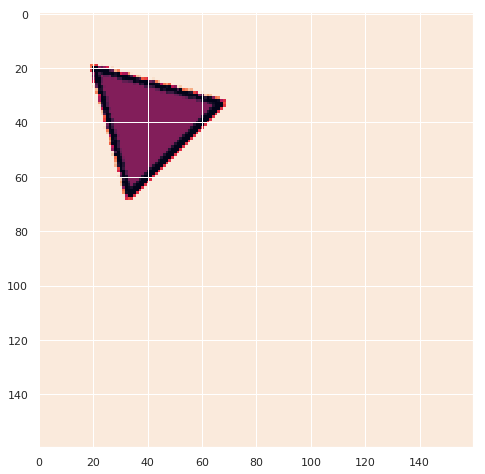

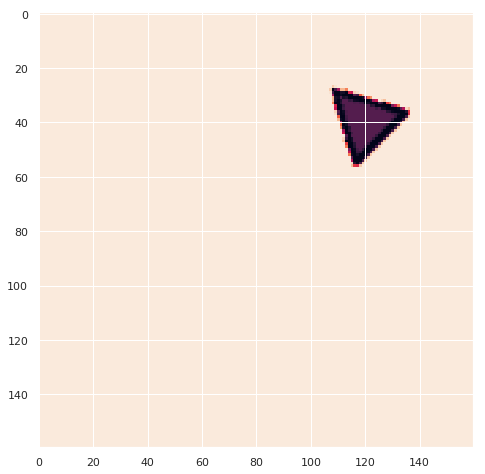

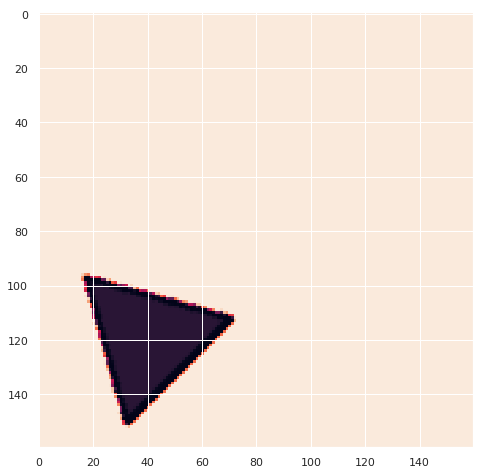

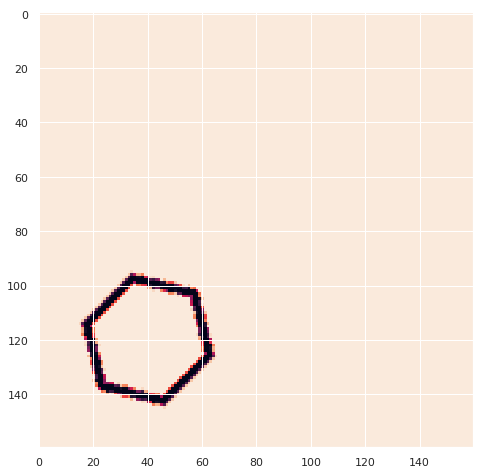

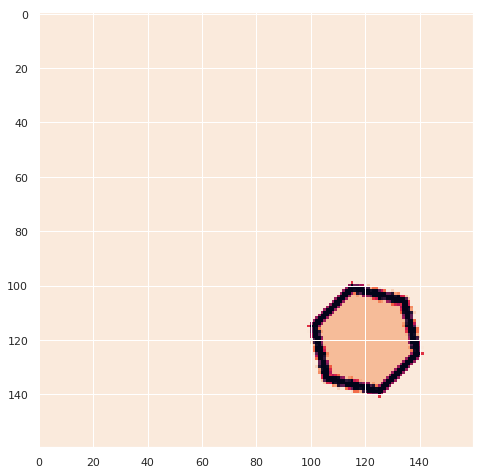

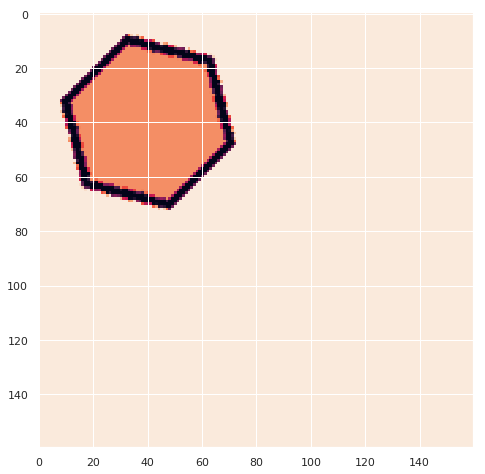

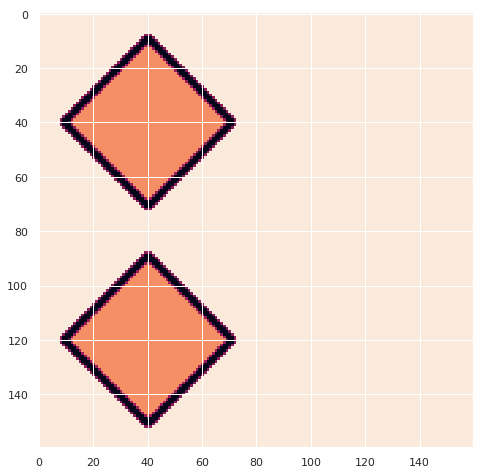

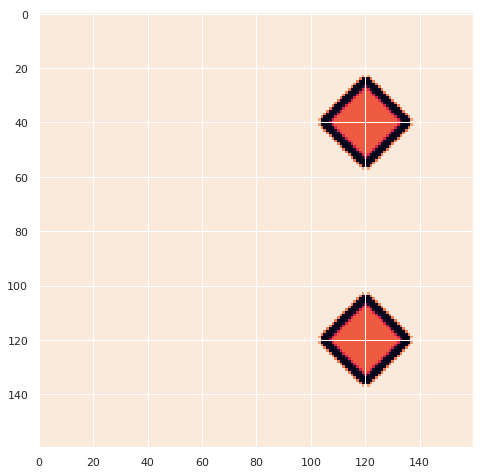

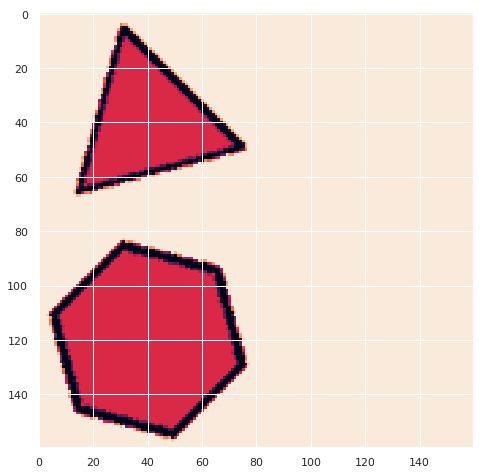

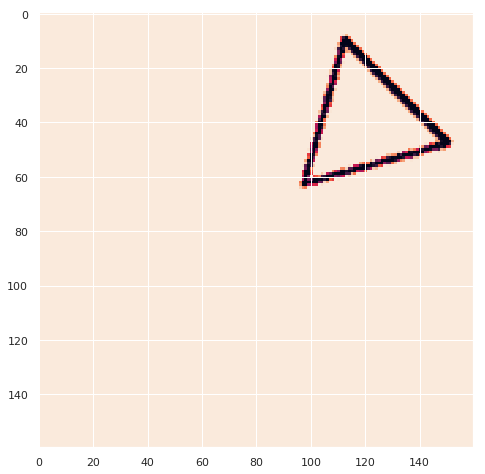

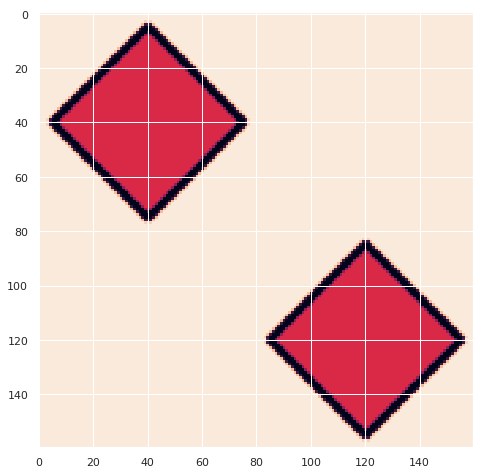

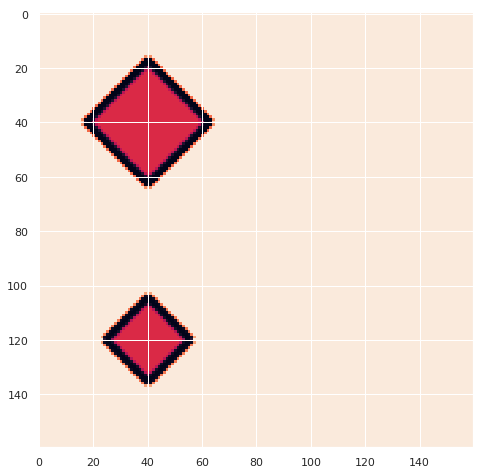

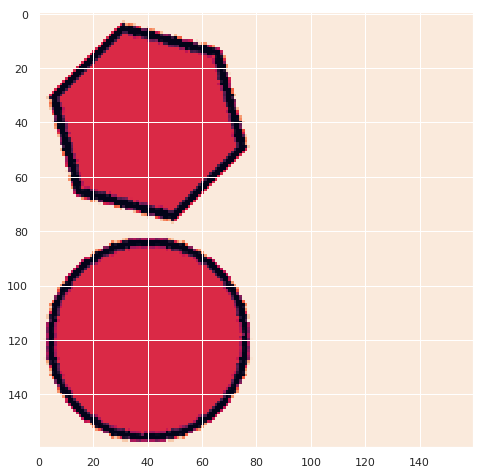

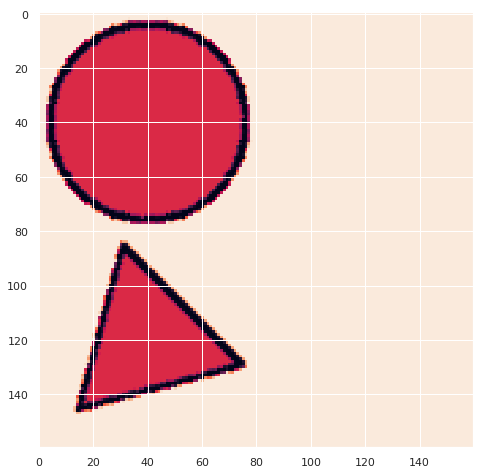

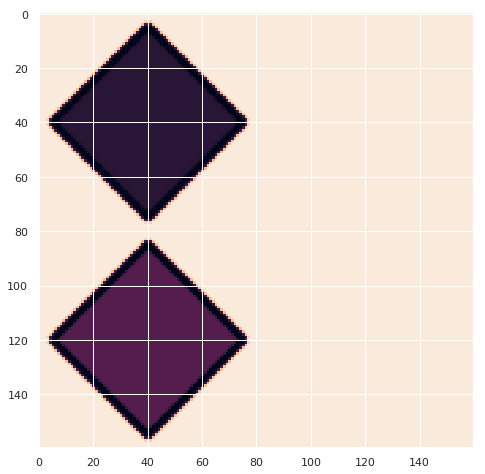

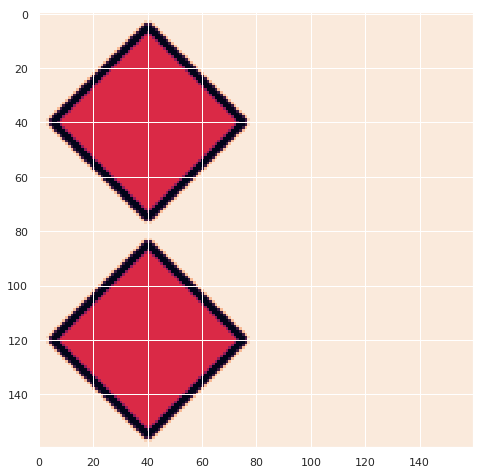

In [186]:
for i in range(16):
#     plt.ion()
    plt.figure()
    plt.imshow(a['image'][i])
